<a href="https://colab.research.google.com/github/ErickMM98/covid-ct-network-analysis/blob/main/own_3D_mfdfa_image_classification_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My own structure.

In [1]:
#@title Mounting Drive (i don0t kown )

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title All packages

import matplotlib.pyplot as plt
import os
import zipfile
import numpy as np
from natsort import natsorted, ns
from tqdm.auto import tqdm
from skimage.transform import resize
import random

from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [3]:
#@title General values and paths.

path_binary_covid = '/content/drive/MyDrive/covid-ct-bronquial-tree/binary_arrays/covid'
path_binary_normal = '/content/drive/MyDrive/covid-ct-bronquial-tree/binary_arrays/normal'

lim_images = 30

To make the model easier to understand, we structure it into blocks.
The architecture of the 3D CNN used in this example
is based on [this paper](https://arxiv.org/abs/2007.13224).

In [4]:
#@title Preparation of COVID cases
foo_path = path_binary_covid
array_covid_images = []
array_covid_target = []

count_cases = 0
for patid in tqdm(os.listdir(foo_path)):
  path_images = os.path.join(foo_path, patid, 'images')
  list_all_images = os.listdir(path_images)
  sample_data = None
  sort_images = None

  array_imgs_patid = []

  if len(list_all_images) >= lim_images:
    sample_data = np.random.choice(list_all_images,size= lim_images, replace=False)
    sort_images = natsorted(sample_data)
  else:
    continue
  
  #Read the images
  for img_py in sort_images:
    path_single_image = os.path.join(path_images, img_py )
    array_img = np.load(path_single_image)

    min = 0
    max = np.max(array_img.ravel())
    array_img[array_img < min] = min
    array_img[array_img > max] = max
    array_img = (array_img - min) / (max - min)

    image_resized = resize(array_img, (128, 128),
                       anti_aliasing=True)
    
    array_imgs_patid.append( image_resized )

  array_covid_images.append( array_imgs_patid )
  array_covid_target.append( 1 )
  count_cases += 1

print(count_cases)

  0%|          | 0/203 [00:00<?, ?it/s]

142


In [5]:
#@title Preparation of normal cases
foo_path = path_binary_normal
array_normal_images = []
array_normal_target = []

count_cases = 0
for patid in tqdm(os.listdir(foo_path)):
  path_images = os.path.join(foo_path, patid, 'images')
  list_all_images = os.listdir(path_images)
  sample_data = None
  sort_images = None

  array_imgs_patid = []

  if len(list_all_images) > lim_images:
    sample_data = np.random.choice(list_all_images,size= lim_images, replace=False)
    sort_images = natsorted(sample_data)
  else:
    continue
  
  #Read the images
  for img_py in sort_images:
    path_single_image = os.path.join(path_images, img_py )
    array_img = np.load(path_single_image)

    min = 0
    max = np.max(array_img.ravel())
    array_img[array_img < min] = min
    array_img[array_img > max] = max
    array_img = (array_img - min) / (max - min)

    image_resized = resize(array_img, (128, 128),
                       anti_aliasing=True)
    array_imgs_patid.append( image_resized )

  array_normal_images.append( array_imgs_patid )
  array_normal_target.append( 0 )
  count_cases += 1

print(count_cases)

  0%|          | 0/157 [00:00<?, ?it/s]

145


In [6]:
#@title Split data: Train and test datasets

normal_ct = np.array(array_normal_images).transpose(0,2,3,1).astype(np.float32)
covid_ct = np.array(array_covid_images).transpose(0,2,3,1).astype(np.float32)

normal_labels = np.array( array_normal_target ) 
covid_labels = np.array( array_covid_target )

#print(len(normal_labels))
max_sample = np.min( ( len(normal_labels), len(covid_labels) ))
limit_split = int( max_sample * (2/3) )
print(max_sample)


x_train = np.concatenate((covid_ct[:limit_split], normal_ct[:limit_split]), axis=0)
y_train = np.concatenate((covid_labels[:limit_split], normal_labels[:limit_split]), axis=0)
x_val = np.concatenate((covid_ct[limit_split:max_sample], normal_ct[limit_split:max_sample]), axis=0)
y_val = np.concatenate((covid_labels[limit_split:max_sample], normal_labels[limit_split:max_sample]), axis=0)

#print(limit_split)
#print(x_train.shape)
#print(covid_ct.shape)
#fig, ax = plt.subplots()
#ax.imshow(covid_ct[0][:, :, 5] )
#ax.hist(normal_ct[0][:, :, 5].ravel() )
#plt.imshow(np.squeeze(image[:, :, 5]), cmap="gray")


142


In [7]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [8]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

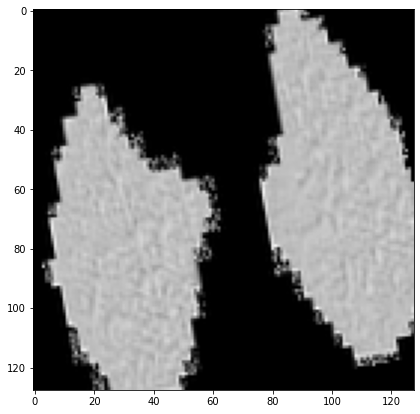

In [ ]:

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
#print("Dimension of the CT scan is:", image.shape)

fig, ax = plt.subplots()
fig.set_size_inches([7,7])
plt.imshow(np.squeeze(image[:, :, 5]), cmap="gray")
fig.show()

#print( len(train_dataset ))

# The model

In [9]:
#@title Define a 3D convolutional neural network

def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01) )(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1,kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),
                           activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=30)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 30, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 28, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 14, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 14, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 12, 64)    110656    
                                                             

## Train model

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
#initial_learning_rate = 0.0125
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 300
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb]#, early_stopping_cb],
)

Epoch 1/500
94/94 - 25s - loss: 0.5435 - acc: 0.8032 - val_loss: 0.6753 - val_acc: 0.6458 - 25s/epoch - 262ms/step
Epoch 2/500
94/94 - 23s - loss: 0.5107 - acc: 0.8245 - val_loss: 0.5992 - val_acc: 0.7917 - 23s/epoch - 245ms/step
Epoch 3/500
94/94 - 23s - loss: 0.4731 - acc: 0.8351 - val_loss: 0.5991 - val_acc: 0.7604 - 23s/epoch - 245ms/step
Epoch 4/500
94/94 - 23s - loss: 0.4888 - acc: 0.8457 - val_loss: 0.4121 - val_acc: 0.9062 - 23s/epoch - 244ms/step
Epoch 5/500
94/94 - 23s - loss: 0.4797 - acc: 0.8404 - val_loss: 0.6569 - val_acc: 0.7812 - 23s/epoch - 242ms/step
Epoch 6/500
94/94 - 25s - loss: 0.4958 - acc: 0.8404 - val_loss: 0.6449 - val_acc: 0.6458 - 25s/epoch - 269ms/step
Epoch 7/500
94/94 - 23s - loss: 0.5372 - acc: 0.8032 - val_loss: 0.7022 - val_acc: 0.6875 - 23s/epoch - 243ms/step
Epoch 8/500
94/94 - 25s - loss: 0.4846 - acc: 0.8457 - val_loss: 0.6588 - val_acc: 0.6771 - 25s/epoch - 268ms/step
Epoch 9/500
94/94 - 23s - loss: 0.4662 - acc: 0.8564 - val_loss: 0.7009 - val_ac

In [ ]:
#@title Save the model
model.save('/content/')

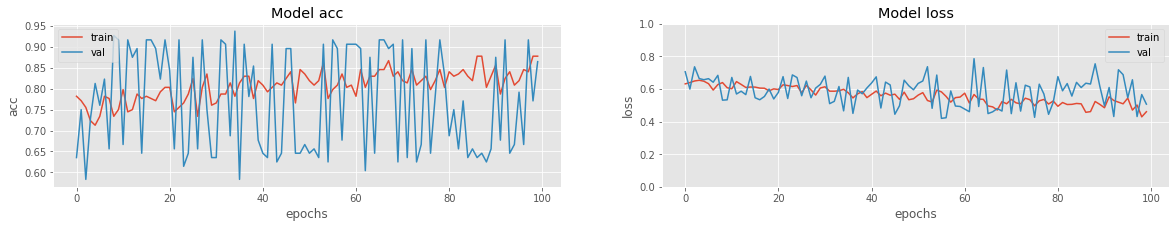

In [14]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
    if i == 1:
      ax[i].set_ylim([0,1])

fig.savefig('resultsoverfitting')

This model is 11.68 percent confident that CT scan is normal
This model is 88.32 percent confident that CT scan is COVID
1


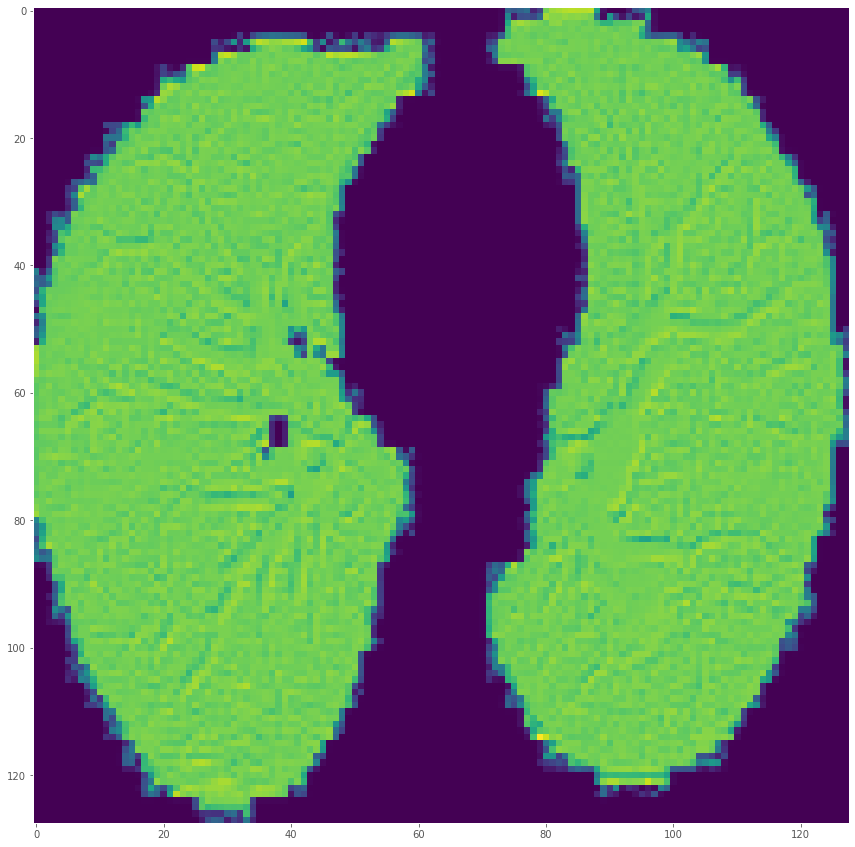

In [ ]:
model.load_weights("3d_image_classification.h5")
i = 10
x_val[i][:,:,1]
prediction = model.predict(np.expand_dims(x_val[i], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "COVID"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

fig, ax = plt.subplots()
fig.set_size_inches([15,15])
ax.imshow(x_val[i][:,:,17])
ax.grid(False)
print(y_val[i])

In [ ]:
#Checar dimensiones 
#Documentación /!!!!
model.get_weights()[0]

array([[[[[-0.0162942 , -0.04706023, -0.04456237, ...,  0.00203249,
           -0.03328082,  0.03669399]],

         [[-0.02780216, -0.01616184, -0.05162345, ..., -0.04745556,
           -0.0226969 ,  0.00172085]],

         [[ 0.02716129, -0.055631  , -0.03980419, ..., -0.005003  ,
           -0.04041763, -0.01170446]]],


        [[[-0.05103075, -0.04565831, -0.01426023, ..., -0.03634897,
           -0.03498891,  0.04656889]],

         [[-0.04191218, -0.00339009, -0.0412517 , ..., -0.05351616,
            0.03137258, -0.053907  ]],

         [[-0.03829645, -0.02513663,  0.0036064 , ..., -0.01951244,
            0.04345806, -0.01139365]]],


        [[[ 0.03480155,  0.013025  , -0.02517834, ..., -0.05147381,
           -0.05897722,  0.03895327]],

         [[ 0.03486011,  0.02027942, -0.01705267, ..., -0.00295687,
           -0.03258017, -0.04487026]],

         [[ 0.0504592 , -0.00057033,  0.04120761, ..., -0.00117595,
           -0.02555928,  0.00767093]]]],



       [[[[ 0.029664

# Some test codes in order to confirm it.